<a href="https://colab.research.google.com/github/Abdul-AI-creator/Abdul-AI-creator/blob/main/SKLEARN_Project_(_L1_based_models_for_Sparse_Signals).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKLEARN L1-based models for Sparse Signals PROJECT

1. Generate synthetic dataset

In [12]:
import numpy as np

rng  = np.random.RandomState(0)
n_samples , n_features ,n_informative = 50,100,10
time_step = np.linspace(-3,4,n_samples)
freqs = 2 * np.pi * np.sort(rng.rand(n_features)) / 0.01
X= np.zeros((n_samples , n_features))

for i in range(n_features):
  X[:, i]=np.sin(freqs[i] * time_step)   #  selects the i-th column of the matrix X for all rows

idx = np.arange(n_features)
true_coef = (-1) ** idx *np.exp(-idx / 10)
true_coef[n_informative:]=0                # sparsify coef
y=np.dot(X,true_coef)

Some of the informative features have close frequencies to induce (anti-)correlations.



In [13]:
freqs[:n_informative]

array([ 2.9502547 , 11.8059798 , 12.63394388, 12.70359377, 24.62241605,
       37.84077985, 40.30506066, 44.63327171, 54.74495357, 59.02456369])

A random phase is introduced using numpy.random.random_sample and some gaussian noise (implemented by numpy.random.normal) is added to both the features and the target.

In [14]:
for i in range(n_features):
  X[:, i]=np.sin(freqs[i] * time_step + 2 * (rng.random_sample() - 0.5))
  X[:, i] += 0.2 * rng.normal(0,1 ,n_samples)
y += 0.2 * rng.normal(0 ,1 , n_samples)

Work with Matplotlib

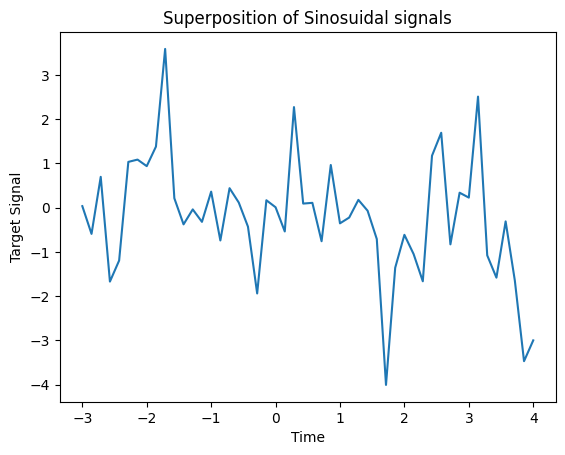

In [15]:
import matplotlib.pyplot as plt
plt.plot(time_step , y)
plt.xlabel('Time')
plt.ylabel('Target Signal')
_ =plt.title("Superposition of Sinosuidal signals")

We `split the data into train and test sets` for simplicity. In practice one should use a `TimeSeriesSplit cross-validation` to estimate the variance of the test score. Here we `set shuffle="False"` as we must not use training data that succeed the testing data when dealing with data that have a temporal relationship.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X , y ,test_size = 0.5 , shuffle = False)

we `compute the performance` of three l1-based models in terms of the goodness of fit `R-squared score` and the fitting time

# Lasso

we `demo a Lasso` with a fixed value of the regularization parameter `alpha`

In [19]:
from time import time
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

t0 = time()
lasso = Lasso(alpha=0.14).fit(X_train , y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso =lasso.predict(X_test)
r2_score_lasso = r2_score(y_test , y_pred_lasso)

print(f"Lasso r-squared on test data : {r2_score_lasso:.3f}")

Lasso fit done in 0.005s
Lasso r-squared on test data : -0.147


Automatic Relevance Determination (ARD)

 It can produce interval estimates for all of the parameters, including the error variance, if required.

In [22]:
from sklearn.linear_model import ARDRegression

t0 = time()
ard = ARDRegression().fit(X_train, y_train)
print(f"ARD fit done in {(time() - t0):.3f}s")
y_pred_ard = ard.predict(X_test)
r2_score_ard = r2_score(y_test , y_pred_ard)
print(f'ARD-squares on test data : {r2_score_ard:.3f}')

ARD fit done in 0.017s
ARD-squares on test data : -0.038


# ElasticNet

ElasticNet is a middle ground between Lasso and Ridge, as it combines a L1 and a L2-penalty.

In [21]:
from sklearn.linear_model import ElasticNet

In [23]:
t0 =time()
enet = ElasticNet(alpha = 0.08, l1_ratio =0.5).fit(X_train,y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test , y_pred_enet)
print(f"ElasticNet squared on test data: {r2_score_enet:.3f}")

ElasticNet fit done in 0.004s
ElasticNet squared on test data: -0.108


# Plot and analysis of the results

we use a `heatmap to visualize the sparsity` of the true and estimated coefficients of the respective linear models.

In [24]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import SymLogNorm

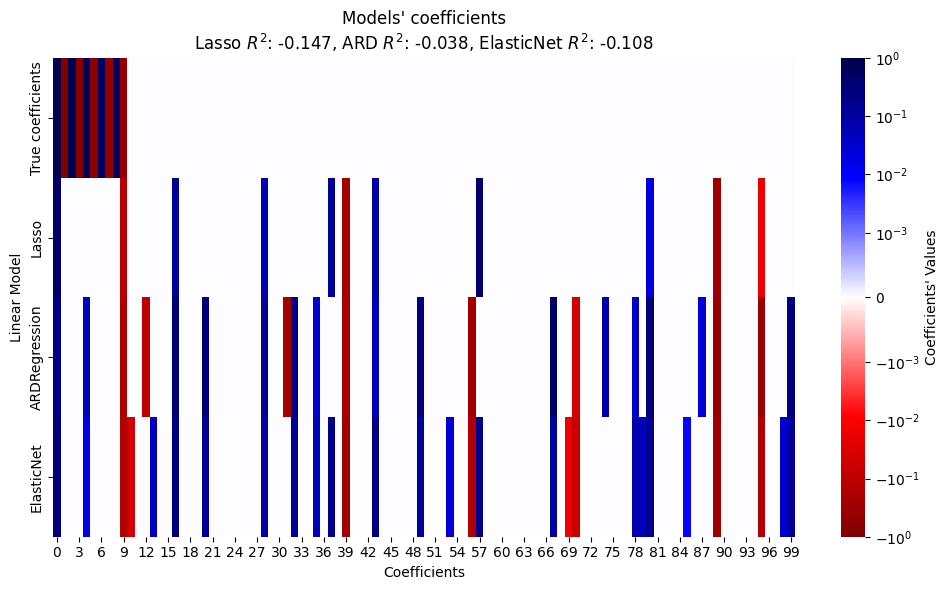

In [27]:
df = pd.DataFrame({
    "True coefficients" :true_coef,
    "Lasso" : lasso.coef_,
    "ARDRegression" : ard.coef_ ,
    "ElasticNet" : enet.coef_ ,
})

plt.figure(figsize=(10, 6))
ax = sns.heatmap(df.T,
                 norm =SymLogNorm(linthresh =10e-4 , vmin =-1 ,vmax= 1),
                 cbar_kws={"label":"Coefficients' Values"},
                 cmap = 'seismic_r',)

plt.ylabel('Linear Model')
plt.xlabel("Coefficients")

plt.title(
    f"Models' coefficients\nLasso $R^2$: {r2_score_lasso:.3f}, "
    f"ARD $R^2$: {r2_score_ard:.3f}, "
    f"ElasticNet $R^2$: {r2_score_enet:.3f}"
)
plt.tight_layout()

ElasticNet yields the best score and captures the most of the predictive features, yet still fails at finding all the true components. Notice that both ElasticNet and ARDRegression result in a less sparse model than a Lasso.